In [94]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',50)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline, Pipeline
from imblearn.under_sampling import NearMiss

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve, RocCurveDisplay)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

In [95]:
import os

In [96]:
os.chdir('C:\\Users\\Ajay Jacob\\Documents\\Python Scripts\\Bank Customer Churn Analysis')

### Importing Dataset

In [97]:
data = pd.read_csv('BankCustomerChurn_Dataset.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [99]:
data.shape

(10000, 14)

In [100]:
data.isnull().sum().sum()

0

In [101]:
data.drop(columns=['RowNumber','CustomerId','Surname'],inplace = True)

In [102]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [103]:
data.describe(exclude='number')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


### Exploratory Data Analysis

In [104]:
def age_group(age):
    if age <=30:
        return 'age_group (18-30)'
    elif ((age >30) & (age<=45)):
        return 'age_group (31-45)'
    elif ((age >45) & (age<=60)):
        return 'age_group (46-60)'
    elif ((age >61) & (age<=75)):
        return 'age_group (61-75)'
    else:
        return 'age_group (75+)'
    

def active(cust):
    if cust ==0:
        return 'Inactive'
    else:
        return 'Active'

In [105]:
data['age_group'] = data.Age.apply(age_group)
data['active_mem'] = data.IsActiveMember.apply(active)

In [106]:
gender_churn = data.groupby(['Gender','Exited'])[['Exited']].size()
gender_per_churn = gender_churn.groupby(level=[0]).apply(lambda x: x/x.sum()).reset_index()
gender_per_churn.columns = ['Gender','Exited','Percent']

country_churn = data.groupby(['Geography','Exited']).size().reset_index()
country_churn.columns = ['Geography','Exited','count']

product_churn = data.groupby(['NumOfProducts','Exited']).size().reset_index()
product_churn.columns = ['Products','Exited','count']

tenure_churn = data.groupby(['Tenure','Exited']).size()
tenure_churn.columns = ['Tenure','Exited','count']
tenure_churn_per = tenure_churn.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
tenure_churn_per.columns = ['Tenure','Exited','percent']

balance_churn = data.groupby(['Balance','Exited']).size()
balance_churn_per = balance_churn.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
balance_churn_per.columns = ['Balance','Exited','percent']

cust_age = data.groupby(['age_group','Exited']).size()
churn_perc = cust_age.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
churn_perc.columns = ['age_group','Exited','churn_percent']

active_member = data.groupby(['active_mem','Exited']).size()
active_churn = active_member.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
active_churn.columns = ['active_mem','Exited','percent']

In [107]:
churn_rate = (data['Exited'].sum()*100/len(data))

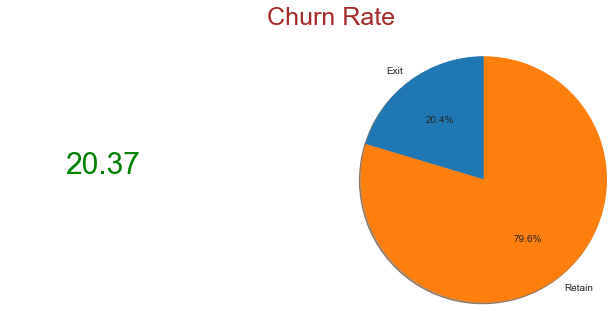

In [108]:
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
value = churn_rate

ax1.text(0.5, 0.5, f"{value:,}", fontsize=30, ha="center", va="bottom",color = 'green')
ax1.axis('off')

sizes = [data.Exited[data['Exited']== 1].count(), data.Exited[data['Exited']==0].count()]
ax2.pie(sizes,labels=['Exit','Retain'],autopct='%1.1f%%',shadow=True, startangle=90,radius=2.0)

plt.tight_layout(pad=3.6,w_pad=6.0,h_pad=5.0,)
plt.subplots_adjust(wspace=1.0)
fig.suptitle('Churn Rate',fontsize=25,color='brown')

plt.show()

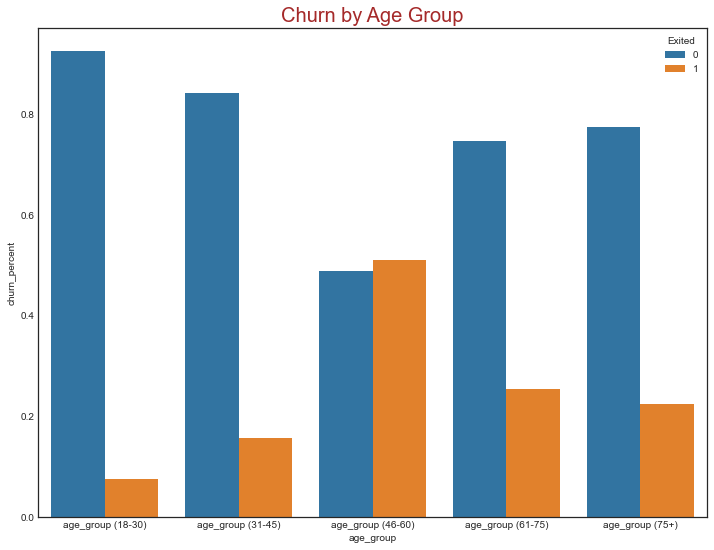

In [109]:
plt.figure(figsize=(12,9))
sns.barplot(data=churn_perc,x='age_group',y='churn_percent',hue='Exited')
plt.title('Churn by Age Group',fontsize=20,color='brown')
plt.show()

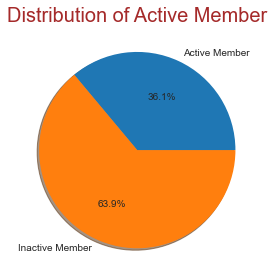

In [110]:
active_churn = data[(data['active_mem']=='Active') & (data['Exited']==1)].shape[0]
inactive_churn = data[(data['active_mem']=='Inactive') & (data['Exited']==1)].shape[0]
cust = [active_churn,inactive_churn]


plt.pie(cust,labels=['Active Member','Inactive Member'],autopct='%1.1f%%',shadow=True,radius=1.0,center=(0,1))
plt.title('Distribution of Active Member',fontsize=20,color='brown')
plt.tight_layout()

In [111]:
credit_churn = data[(data['HasCrCard']==1) & (data['Exited']==1)].shape[0]
non_cred_churn = data[(data['HasCrCard']==0) & (data['Exited']==1)].shape[0]

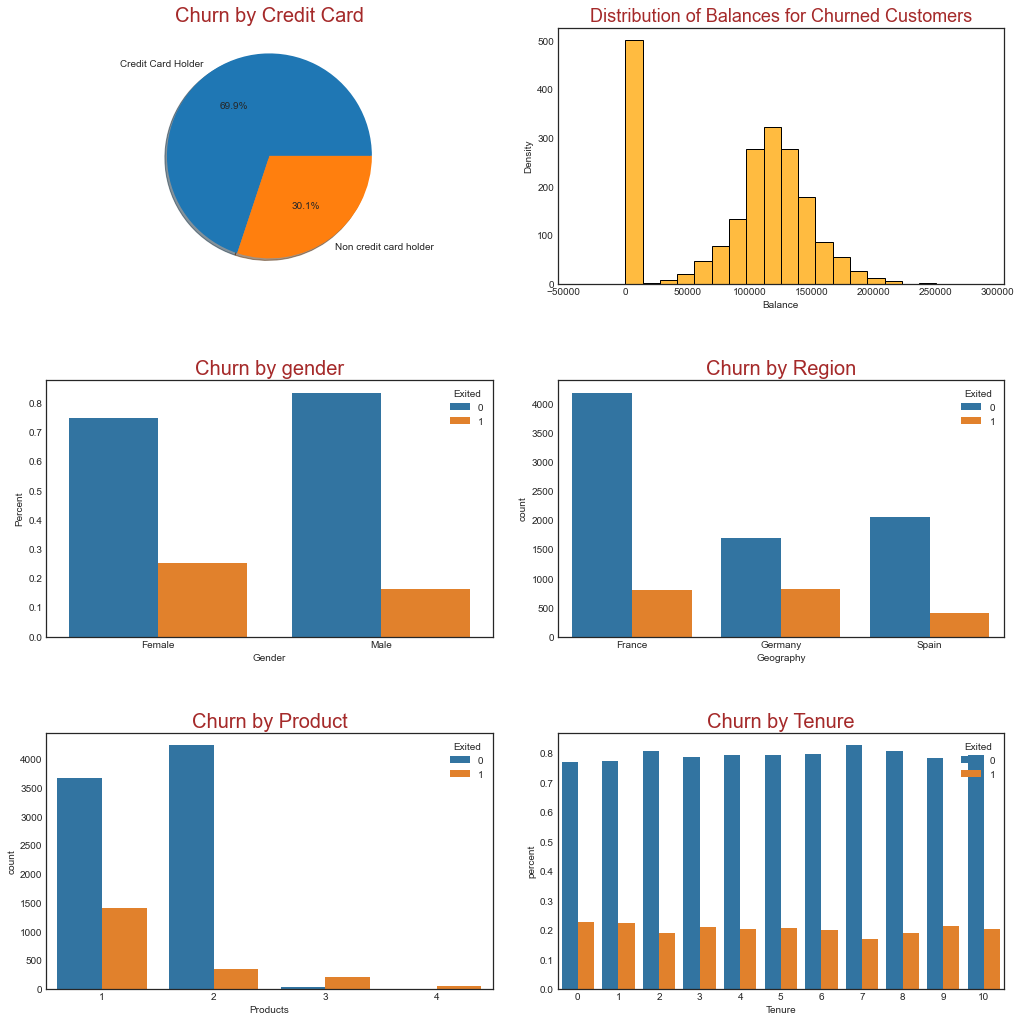

In [112]:
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=False,sharey=False,figsize=(15,15))


size = [credit_churn,non_cred_churn]
axes[0,0].pie(size,labels=['Credit Card Holder','Non credit card holder'],autopct='%1.1f%%',shadow=True,radius=1.0)
axes[0,0].set_title('Churn by Credit Card',fontsize = 20,color='brown')

churned_balances = data.loc[data['Exited'] == 1, 'Balance']

# Plot the histogram
sns.kdeplot(churned_balances, shade=True,ax=axes[0,1])
sns.histplot(churned_balances, kde=False, color="orange",ax=axes[0,1])
axes[0,1].set_title("Distribution of Balances for Churned Customers",color='brown',fontsize=18)
axes[0,1].set_xlabel("Balance")
axes[0,1].set_ylabel("Density")


sns.barplot(data=gender_per_churn,x='Gender',y='Percent',hue='Exited',ax=axes[1,0])
axes[1,0].set_title('Churn by gender',fontsize = 20,color='brown')

sns.barplot(data=country_churn,x='Geography',y='count',hue='Exited',ax=axes[1,1])
axes[1,1].set_title('Churn by Region',fontsize = 20,color='brown')

sns.barplot(data=product_churn,x='Products',y='count',hue='Exited',ax=axes[2,0])
axes[2,0].set_title('Churn by Product',fontsize = 20,color='brown')

sns.barplot(data=tenure_churn_per,x='Tenure',y='percent',hue='Exited',ax=axes[2,1])
axes[2,1].set_title('Churn by Tenure',fontsize = 20,color='brown')


plt.tight_layout(pad=3.6,w_pad=2.6,h_pad=5.0,)
plt.show()

In [113]:
corr_val = np.abs(data.corrwith(data['Exited']))
corr_val

CreditScore        0.027094
Age                0.285323
Tenure             0.014001
Balance            0.118533
NumOfProducts      0.047820
HasCrCard          0.007138
IsActiveMember     0.156128
EstimatedSalary    0.012097
Exited             1.000000
dtype: float64

### Encoding Categorical variables

In [114]:
data = pd.get_dummies(data,drop_first=True)

In [115]:
data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,age_group_age_group (31-45),age_group_age_group (46-60),age_group_age_group (61-75),age_group_age_group (75+),active_mem_Inactive
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0,1,0,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0,0,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,1,0,0,0,1
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0,1,0,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,1,0,0,0,0
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0,1,0,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1,1,0,0,0,1


In [116]:
data.drop(columns=['age_group_age_group (31-45)','age_group_age_group (46-60)','age_group_age_group (61-75)','age_group_age_group (75+)','active_mem_Inactive'],inplace=True)

In [117]:
data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


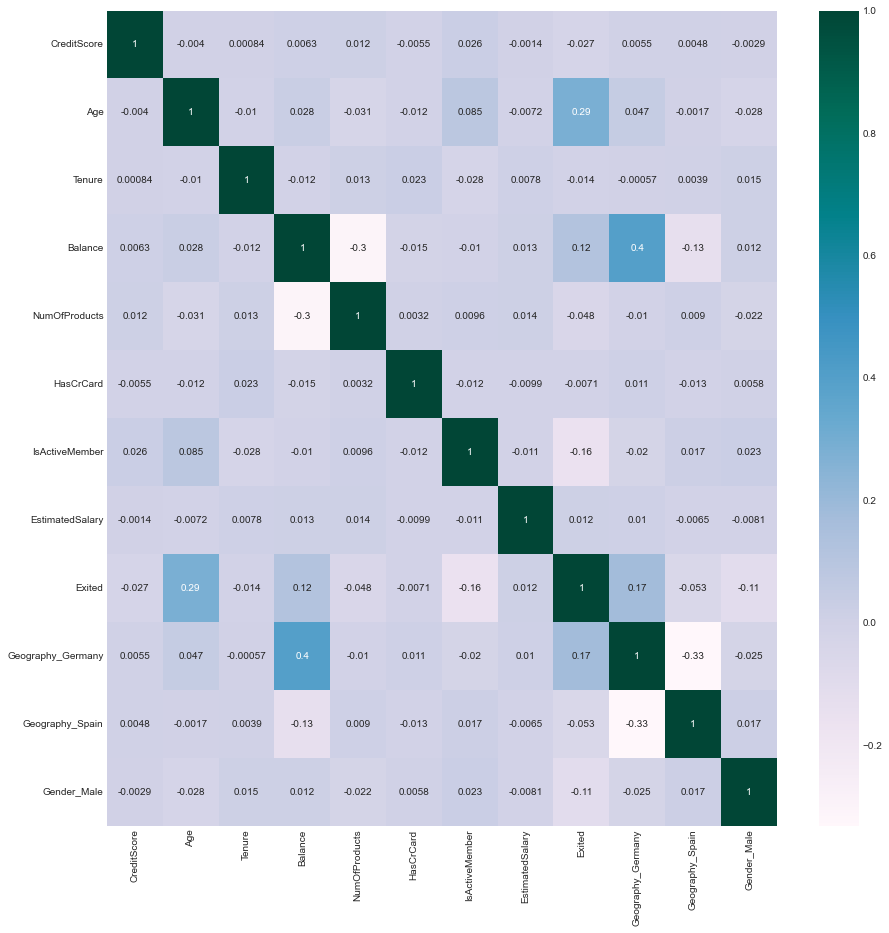

In [118]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,cmap="PuBuGn")

plt.show()

### Splitting the dataset into Features (x) and Target (y)

In [119]:
x= data[data.columns.difference(['Exited'])]
y = data['Exited']

In [120]:
print('shape of x:',x.shape)
print('shape of y:',y.shape)

shape of x: (10000, 11)
shape of y: (10000,)


### Splitting into Testing and Training datasets

In [121]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.3,random_state=123)

In [122]:
print('shape of train_x:',train_x.shape)
print('shape of train_y:',train_y.shape)
print('shape of test_x:',test_x.shape)
print('shape of test_y:',test_y.shape)

shape of train_x: (7000, 11)
shape of train_y: (7000,)
shape of test_x: (3000, 11)
shape of test_y: (3000,)


### Resampling

In [123]:
x_res,y_res = SMOTE().fit_resample(x,y)

In [124]:
y_res.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

In [125]:
x_res

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,42,0.000000,619,101348.880000,0,0,0,1,1,1,2
1,41,83807.860000,608,112542.580000,0,0,1,0,1,1,1
2,42,159660.800000,502,113931.570000,0,0,0,1,0,3,8
3,39,0.000000,699,93826.630000,0,0,0,0,0,2,1
4,43,125510.820000,850,79084.100000,0,0,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
15921,55,110886.375264,666,134370.797321,1,0,0,1,0,1,9
15922,40,0.000000,762,28271.722057,0,0,0,1,0,1,5
15923,37,122763.977382,681,97776.417643,0,1,0,0,0,1,7
15924,40,130526.274930,704,58277.189991,0,0,0,0,0,1,7


In [126]:
train_x,test_x,train_y,test_y = train_test_split(x_res,y_res,test_size=0.3,random_state=123)

In [127]:
print('shape of train_x:',train_x.shape)
print('shape of train_y:',train_y.shape)

shape of train_x: (11148, 11)
shape of train_y: (11148,)


In [128]:
test_x

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
8117,34,0.00,624,582.590000,0,0,1,1,0,1,6
8265,40,140306.38,618,160618.610000,0,1,0,1,0,1,0
5455,45,116585.97,805,189428.750000,0,1,0,1,0,1,9
10787,61,0.00,578,130875.116015,0,0,0,0,0,1,2
337,33,0.00,649,2010.980000,1,0,0,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...
6625,41,112119.48,657,17536.820000,0,0,1,1,0,1,6
9921,36,65349.71,757,64539.640000,1,1,0,0,0,1,1
2141,18,0.00,674,55753.120000,1,0,0,1,1,2,7
3214,33,68193.72,572,19998.310000,1,0,0,1,0,1,9


### Feature scaling

In [129]:
sc=StandardScaler()
st= sc.fit(train_x)

In [130]:
train_x_std = pd.DataFrame(st.transform(train_x),columns=train_x.columns)
test_x_std = pd.DataFrame(st.transform(test_x),columns=test_x.columns)
test_x_std

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,-0.692771,-1.336477,-0.262200,-1.733331,-0.840640,-0.575693,2.172523,0.773337,-0.760063,-0.728874,0.430544
1,-0.092591,0.950341,-0.327735,1.035195,-0.840640,1.737037,-0.460294,0.773337,-0.760063,-0.728874,-1.774865
2,0.407559,0.563728,1.714755,1.533593,-0.840640,1.737037,-0.460294,0.773337,-0.760063,-0.728874,1.533249
3,2.008039,-1.336477,-0.764631,0.520651,-0.840640,-0.575693,-0.460294,-1.293097,-0.760063,-0.728874,-1.039729
4,-0.792801,-1.336477,0.010860,-1.708621,1.189571,-0.575693,-0.460294,0.773337,-0.760063,1.014419,-1.039729
...,...,...,...,...,...,...,...,...,...,...,...
4773,0.007439,0.490930,0.098239,-1.440033,-0.840640,-0.575693,2.172523,0.773337,-0.760063,-0.728874,0.430544
4774,-0.492711,-0.271358,1.190479,-0.626913,1.189571,1.737037,-0.460294,-1.293097,-0.760063,-0.728874,-1.407297
4775,-2.293252,-1.336477,0.283920,-0.778914,1.189571,-0.575693,-0.460294,0.773337,1.315680,1.014419,0.798112
4776,-0.792801,-0.225004,-0.830165,-1.397451,1.189571,-0.575693,-0.460294,0.773337,-0.760063,-0.728874,1.533249


### Model Building

In [131]:
def metric_table(y_true,y_pred,y_proba,model_name):
    prec = precision_score(y_true,y_pred)
    acc = accuracy_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)
    roc = roc_auc_score(y_true,y_proba[:, 1])
    metric = pd.DataFrame(data={
        "model" : model_name,
        "Precision" : prec,
        "Accuracy" : acc,
        "Recall" : recall,
        "F1-score" : f1,
        "ROC_AUC" : roc
    },index=[0])
    return metric

### This function calculates and returns a DataFrame containing various performance metrics for a classification model. These metrics include precision, accuracy, recall, F1-score, and ROC AUC score.

Parameters:
- y_true: The true labels for the test data.
- y_pred: The predicted labels from the model.
- y_proba: The predicted probabilities from the model, typically for the positive class.
- model_name: A string representing the name of the model being evaluated.
    
Metrics:
- precision score, which is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives).
- accuracy score, which is the ratio of correctly predicted instances (true positives + true negatives) to the total number of instances.
-  recall score, which is the ratio of true positive predictions to the total number of actual positives (true positives + false negatives).
- F1-score, which is the harmonic mean of precision and recall, providing a balance between the two.
- the ROC AUC score, which is the area under the Receiver Operating Characteristic curve. It measures the ability of the model to distinguish between classes. The y_proba[:, 1] selects the probabilities for the positive class.

In [132]:
def roc_curve_plot(Y_pred, Y_true, Y_pred_pobablities, model_name):
    Y_pp = Y_pred_pobablities[:, 1]
    fpr, tpr, threshold1 = roc_curve(Y_true, Y_pp )
    
    fig, ax = plt.subplots(nrows=1, ncols= 1, figsize = (7,5), constrained_layout = True)
    ax.plot(fpr, tpr, label='ROC Score: {:.5f}'.format(roc_auc_score(Y_true, Y_pp)),color='Red')
    ax.set_title(f"{model_name} ROC Curve ", fontdict = {"fontsize": 18})
    ax.set_xlabel("False Positive Rate", fontdict = {"fontsize": 15} )
    ax.set_ylabel("True Positive Rate", fontdict = {"fontsize": 15})
    ax.legend(loc = 4, fontsize = 14 )

    plt.show()

### Logistic Regression

In [133]:
import copy
train_x_lr = copy.deepcopy(train_x_std)
test_x_lr = copy.deepcopy(test_x_std)

###### This code is used to create deep copies of the train_x_std and test_x_std DataFrames. The purpose of deep copying is to create completely independent copies of these DataFrames, so that changes made to the copied DataFrames (train_x_lr and test_x_lr) do not affect the original DataFrames (train_x_std and test_x_std).

In [134]:
lr=LogisticRegression()

lr_model = lr.fit(train_x_lr,train_y)

In [135]:
lr_pred = lr_model.predict(test_x_lr)
lr_prob = lr_model.predict_proba(test_x_lr)

In [136]:
metric_table(test_y,lr_pred,lr_prob,'LogisticRegression')

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,LogisticRegression,0.76939,0.775638,0.78237,0.775826,0.85619


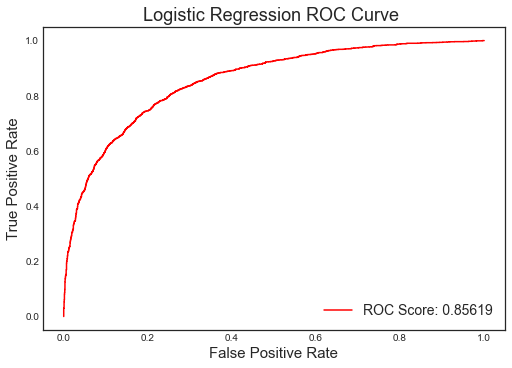

In [137]:
roc_curve_plot(lr_pred,test_y,lr_prob,"Logistic Regression")

### K-Nearest Neighbour

In [138]:
train_x_knn = copy.deepcopy(train_x_std)
test_x_knn = copy.deepcopy(test_x_std)

In [139]:
knn= KNeighborsClassifier()
knn_model = knn.fit(train_x_knn,train_y)

knn_pred = knn_model.predict(test_x_knn)
knn_prob = knn_model.predict_proba(test_x_knn)

In [140]:
metric_table(test_y,knn_pred,knn_prob,"KNN")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,KNN,0.805945,0.813939,0.823281,0.814521,0.882064


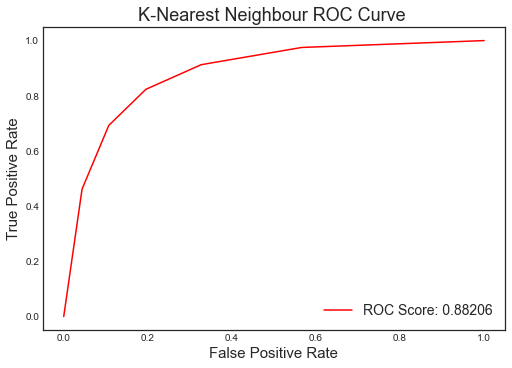

In [141]:
roc_curve_plot(knn_pred,test_y,knn_prob,"K-Nearest Neighbour")

### Decision Tree Classifier

In [142]:
dt = DecisionTreeClassifier()
dt_model = dt.fit(train_x_std,train_y)

In [143]:
dt_pred = dt_model.predict(test_x_std)
dt_prob = dt_model.predict_proba(test_x_std)

In [144]:
metric_table(test_y,dt_pred,dt_prob,"Decision Tree Classifier")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Decision Tree Classifier,0.776961,0.787568,0.802193,0.789375,0.787677


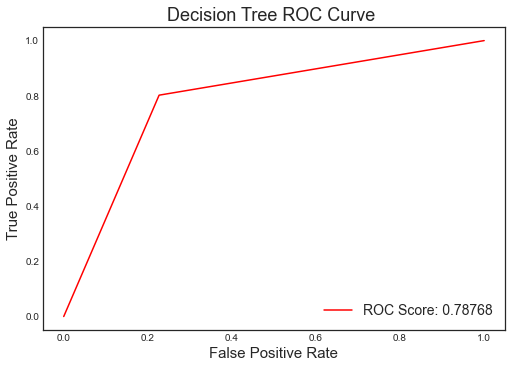

In [145]:
roc_curve_plot(dt_pred,test_y,dt_prob,"Decision Tree")

### Random Forest

In [146]:
rf = RandomForestClassifier()
rf_model = rf.fit(train_x_std,train_y)

In [147]:
rf_pred= rf_model.predict(test_x_std)
rf_prob = rf_model.predict_proba(test_x_std)

In [148]:
metric_table(rf_pred,test_y,rf_prob,"Random Forest")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Random Forest,0.845213,0.851612,0.85422,0.849693,1.0


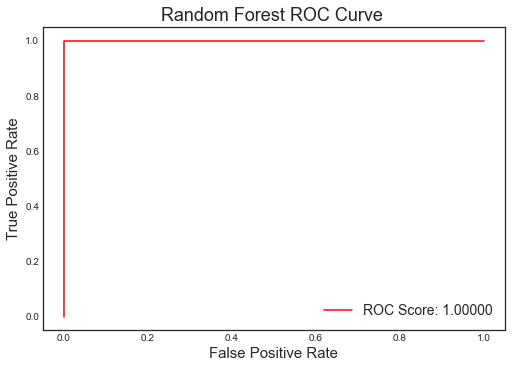

In [149]:
roc_curve_plot(test_y,rf_pred,rf_prob,"Random Forest")

### Gradient Boosting

In [150]:
gb = GradientBoostingClassifier()
gb_model = gb.fit(train_x_std,train_y)

In [151]:
gb_pred = gb_model.predict(test_x_std)
gb_prob = gb_model.predict_proba(test_x_std)

In [152]:
metric_table(test_y,gb_pred,gb_prob,"Gradient Boosting")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Gradient Boosting,0.840329,0.832985,0.819064,0.82956,0.913719


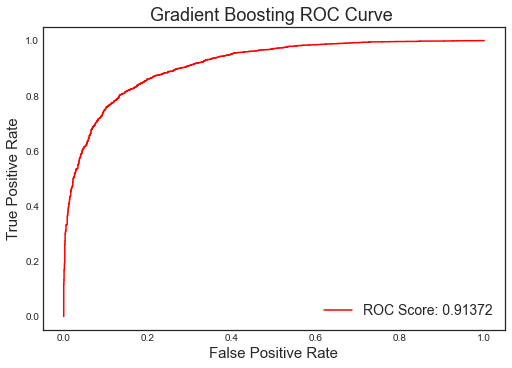

In [153]:
roc_curve_plot(gb_pred,test_y,gb_prob,"Gradient Boosting")

### XGBoost

In [154]:
xg = XGBClassifier()
xgb_model = xg.fit(train_x_std,train_y)

In [155]:
xgb_pred = xgb_model.predict(test_x_std)
xgb_prob = xgb_model.predict_proba(test_x_std)

In [156]:
metric_table(test_y,xgb_pred,xgb_prob,"XGBoost")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,XGBoost,0.855753,0.855797,0.853226,0.854488,0.934868


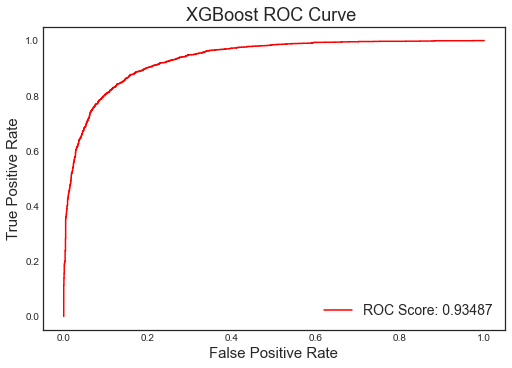

In [157]:
roc_curve_plot(xgb_pred,test_y,xgb_prob,"XGBoost")

In [158]:
def roc_summary_plot(Y_true, Y_probability = [], model_name = []):
    for i in range(len(Y_probability)):
        
        fpr, tpr, threshold1 = roc_curve(Y_true,Y_probability[i][:,1] )
        plt.style.use("seaborn-white")
        plt.figure( num = 1, figsize = (12, 9))
        plt.title("ROC scores summary (tuned model)", fontsize = 18)
        plt.xlabel("False Positive Rate" , fontdict = {"fontsize": 15})
        plt.ylabel("True Positive Rate" , fontdict = {"fontsize": 15})
        plt.plot(fpr, tpr, label='{0} ROC Score: {1}'.format(model_name[i] ,round(roc_auc_score(Y_true, Y_probability[i][:,1] ) ,2)))
        plt.legend(loc = 4, fontsize =13)
    plt.show()

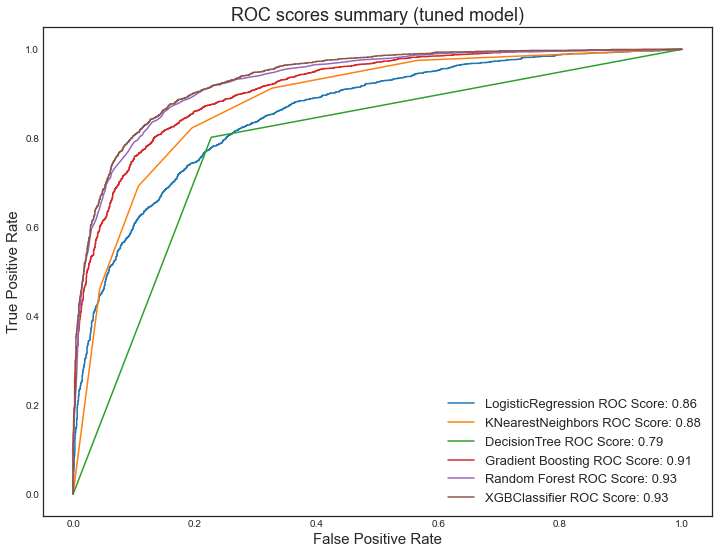

In [159]:
roc_summary_plot(test_y,[lr_prob,knn_prob,dt_prob,gb_prob,rf_prob,xgb_prob],
                 ["LogisticRegression", "KNearestNeighbors", "DecisionTree","Gradient Boosting","Random Forest", "XGBClassifier"])

In [160]:
table_lr = metric_table(test_y,lr_pred,lr_prob,'LogisticRegression')
table_knn = metric_table(test_y,knn_pred,knn_prob,"KNN")
table_dt = metric_table(test_y,dt_pred,dt_prob,"Decision Tree")
table_gb = metric_table(test_y,gb_pred,gb_prob,"Gradient Boosting")
table_rf = metric_table(test_y,knn_pred,knn_prob,"Random Forest")
table_xg = metric_table(test_y,xgb_pred,xgb_prob,"XGBoost")

summary_table = pd.concat([table_lr,table_knn,table_dt,table_gb,table_rf,table_xg])

In [161]:
summary_table

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,LogisticRegression,0.769390,0.775638,0.782370,0.775826,0.856190
0,KNN,0.805945,0.813939,0.823281,0.814521,0.882064
0,Decision Tree,0.776961,0.787568,0.802193,0.789375,0.787677
0,Gradient Boosting,0.840329,0.832985,0.819064,0.829560,0.913719
0,Random Forest,0.805945,0.813939,0.823281,0.814521,0.882064
0,XGBoost,0.855753,0.855797,0.853226,0.854488,0.934868


### Feature Importance

In [162]:
print(rf.feature_importances_)

[0.22506723 0.12029729 0.11698667 0.12377967 0.06280825 0.01485347
 0.02673087 0.01942039 0.11460985 0.10183011 0.07361619]


###### The rf.feature_importances_ attribute provides the importance scores for each feature in a trained Random Forest model. These scores indicate how much each feature contributes to the model's predictions, allowing you to understand which features are most influential.

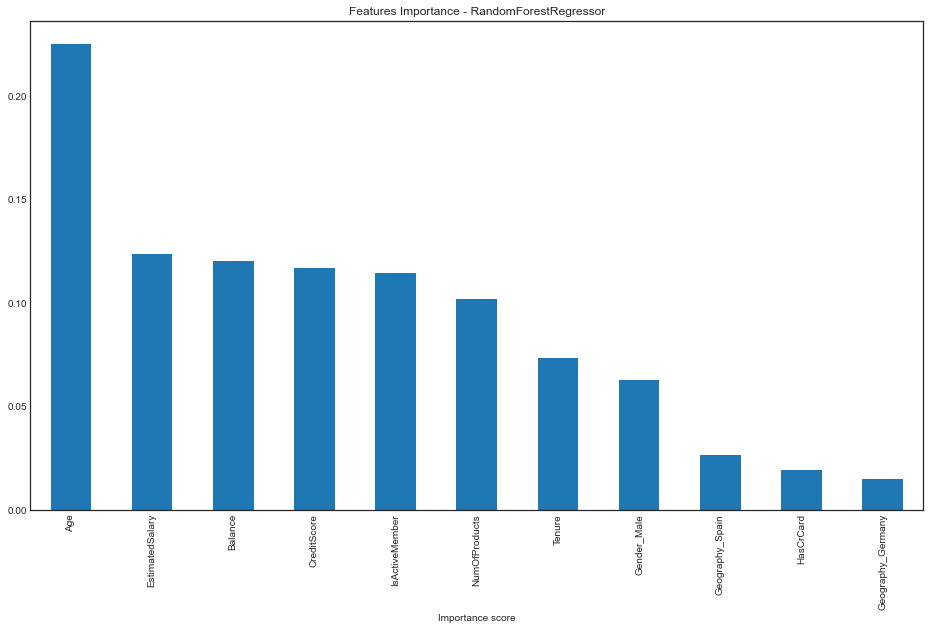

In [163]:
feat_importances = pd.Series(rf.feature_importances_, index=x.columns)
plt.figure(figsize=(16, 9))
feat_importances.nlargest(len(rf.feature_importances_)).plot(kind='bar')
plt.xlabel('Importance score')
plt.title('Features Importance - RandomForestRegressor')
plt.show()

In [164]:
final_df =  feat_importances.nlargest(len(rf.feature_importances_)).index[:8]
final_df

Index(['Age', 'EstimatedSalary', 'Balance', 'CreditScore', 'IsActiveMember',
       'NumOfProducts', 'Tenure', 'Gender_Male'],
      dtype='object')

In [165]:
train_x

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
3055,44,115049.150000,812,165038.410000,1,0,0,1,0,2,4
6982,50,0.000000,753,861.400000,0,0,0,1,1,2,4
1853,41,167545.320000,730,128246.810000,0,0,0,1,0,1,4
11276,43,142328.651804,651,31401.845849,0,1,0,1,0,1,1
9358,29,0.000000,837,41866.260000,0,0,0,1,1,2,9
...,...,...,...,...,...,...,...,...,...,...,...
12252,45,152121.474182,568,164517.599551,0,0,0,0,0,1,4
1346,30,94443.770000,643,165614.400000,1,0,0,1,1,1,5
11646,39,159500.523844,620,80593.815952,0,0,0,1,0,1,8
15725,41,0.000000,644,194006.585259,0,0,0,0,0,1,6


In [166]:
cv = StratifiedKFold(n_splits=5,random_state=123,shuffle=True)

###### This code sets up a cross-validation strategy using StratifiedKFold from the sklearn.model_selection module. It creates a cross-validator object that can be used to split data into training and validation sets in a stratified manner, ensuring that each fold has the same proportion of each class.

### Hyperparameter Tuning

In [167]:
param_grid = {'n_estimators':np.arange(2,50,2),'max_depth':np.arange(2,50,2)}
grid =GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=-1,cv=5,scoring='roc_auc',verbose=True)
grid.fit(train_x_std[final_df],train_y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]),
                         'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])},
             scoring='roc_auc', verbose=True)

##### This code is used to perform hyperparameter tuning for a Random Forest classifier using Grid Search with cross-validation. The goal is to find the optimal combination of n_estimators and max_depth that maximizes the model's performance as measured by the ROC AUC score.

In [168]:
grid.best_params_

{'max_depth': 42, 'n_estimators': 48}

##### The code grid.best_params_ is used to retrieve the best combination of hyperparameters found during the grid search. 

In [169]:
test_x[final_df]

,Age,EstimatedSalary,Balance,CreditScore,IsActiveMember,NumOfProducts,Tenure,Gender_Male
8117,34,582.590000,0.00,624,0,1,6,0
8265,40,160618.610000,140306.38,618,0,1,0,0
5455,45,189428.750000,116585.97,805,0,1,9,0
10787,61,130875.116015,0.00,578,0,1,2,0
337,33,2010.980000,0.00,649,0,2,2,1
...,...,...,...,...,...,...,...,...
6625,41,17536.820000,112119.48,657,0,1,6,0
9921,36,64539.640000,65349.71,757,0,1,1,1
2141,18,55753.120000,0.00,674,1,2,7,1
3214,33,19998.310000,68193.72,572,0,1,9,1


In [170]:
rf = RandomForestClassifier(n_estimators=48,max_depth=42)

In [171]:
rf = rf.fit(train_x_std[final_df],train_y)

In [172]:
new_pred = rf.predict(test_x_std[final_df])
new_prob = rf.predict_proba(test_x_std[final_df])

In [173]:
metric_table(test_y,new_pred,new_prob,"Random Forest")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Random Forest,0.8526,0.847216,0.836778,0.844615,0.920698


In [174]:
XGB_parameters = {
    'n_estimators': [100, 400],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.20],
    'min_child_weight': [1, 10]}

grid_xg = GridSearchCV(estimator=XGBClassifier(),param_grid=XGB_parameters,cv=5,scoring='roc_auc',verbose=True)

##### This code is designed to find the optimal hyperparameters for an XGBoost classifier by performing a grid search with cross-validation. The goal is to identify the best combination of n_estimators, max_depth, learning_rate, and min_child_weight that maximizes the model's performance as measured by the ROC AUC score.

In [175]:
grid_xg = grid_xg.fit(train_x_std[final_df],train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [176]:
grid_xg.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 400}

In [177]:
best_XGB = grid_xg.best_estimator_
best_XGB.fit(train_x[final_df], train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### This code snippet is used to extract the best estimator (i.e., the model with the best combination of hyperparameters found during the grid search) and then fit this best model to the training data.

In [178]:
xg_pred_new =  best_XGB.predict(test_x[final_df])
xg_prob_new = best_XGB.predict_proba(test_x[final_df])

In [179]:
metric_table(test_y,xg_pred_new,xg_prob_new,"XGBoost")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,XGBoost,0.842589,0.847216,0.851118,0.846832,0.927719


In [180]:
grid_xg.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [181]:
score_1 = metric_table(test_y,new_pred,new_prob,"Random Forest")
score_2 = metric_table(test_y,xg_pred_new,xg_prob_new,"XGBoost")
score = pd.concat([score_1,score_2])

In [182]:
score

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Random Forest,0.852600,0.847216,0.836778,0.844615,0.920698
0,XGBoost,0.842589,0.847216,0.851118,0.846832,0.927719


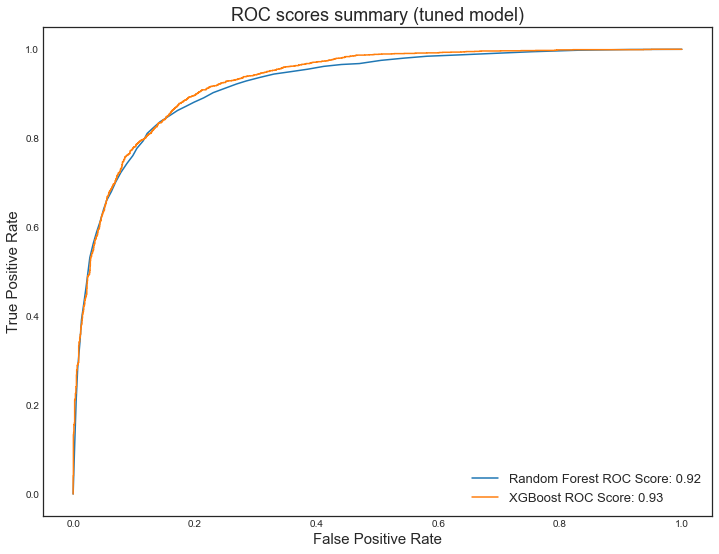

In [183]:
roc_summary_plot(test_y,[new_prob,xg_prob_new],['Random Forest','XGBoost'])